# ViewNormalization is all you need

# Library

In [1]:
import yaml
import glob
import os
import seaborn as sns
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import warnings
import scipy.stats

import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats

import pandas as pd
import scipy.stats
import numpy as np

import warnings
import scipy.stats
import math




#### Check_Config

In [2]:

def check_config(reg_exp, record_list=[]):
    # Find all directories matching pattern
    dirs = glob.glob(reg_exp)
    dirs = [dir for dir in dirs if os.path.isdir(dir)]

    # Initialize dictionary to store the extracted information
    data = {}

    # Iterate over the directories and extract information from config.yaml
    for directory in dirs:
        config_path = os.path.join(directory, 'config.yaml')
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
            # Check for each record in the list
            for record in record_list:
                if record in config:
                    if record not in data:
                        data[record] = [config[record]]
                    else:
                        data[record].append(config[record])
                else:
                    print(f"Record '{record}' not found in directory '{directory}'")

    # Create a DataFrame with the extracted information
    df = pd.DataFrame(data)
    
    # Add 'dir_name' column with directory names
    df['dir_name'] = dirs

    # Set 'dir_name' as the first column
    df = df.set_index('dir_name').reset_index()

    # Display the DataFrame as a table
    return df

#### Plot Bar

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar(df, X="",  Y="", legend=None):
    # when Y is a list, X is the x-axis, plot the bars with same x axis
    if isinstance(Y, list) and X:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the first column as a bar chart
        ax.bar(df[X], df[Y[0]], label=Y[0], color='#3b6291')

        # If there's a second column, plot it as a line
        if len(Y) > 1:
            ax2 = ax.twinx()
            ax2.plot(df[X], df[Y[1]], color='#943c39', label=Y[1])
            ax2.set_ylabel(Y[1])

        ax.set_xlabel(X)
        ax.set_ylabel(Y[0])
        fig.legend(loc="upper right")
        plt.title(f"Bar and Line Plot: {Y} by {X}")

        # Remove grids for each axes
        ax.grid(False)
        if 'ax2' in locals():
            ax2.grid(False)

        plt.tight_layout()
        plt.show()


    # when 'X' and 'Y' are specified, but legend is None
    elif X and Y and legend is None:
        plt.figure(figsize=(10, 6))
        plt.bar(df[X], df[Y])
        plt.xlabel(X, fontsize=12)
        plt.ylabel(Y, fontsize=12)
        plt.title(f"Bar Plot: {Y} by {X}", fontsize=14)
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

    # when 'X', 'legend', and 'Y' are specified
    elif X and legend and Y:
        grouped_df = df.groupby([X, legend])[Y].sum().unstack()

        bar_width = 0.2  # Adjusted bar width
        index = np.arange(len(grouped_df.index))* 0.7
        
        # Dynamically adjust figure size
        fig_width = len(grouped_df.index) * bar_width * 8
        plt.figure(figsize=(fig_width, 6))

        styles = [('white', 'k', '...'), ('white', 'k', '//')]  # Styles for each category
        
        for i, (colname, data) in enumerate(grouped_df.iteritems()):
            color, ec, hatch = styles[i % len(styles)]
            plt.bar(index + i * bar_width, data, width=bar_width, color=color, ec=ec, lw=0.8, hatch=hatch, label=colname)
        
        plt.xlabel(X, fontsize=12)
        plt.ylabel(Y, fontsize=12)
        plt.title(f"Grouped Bar Plot: {Y} by {X} and {legend}", fontsize=14)
        plt.xticks(index + bar_width/2, grouped_df.index, rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(title=legend)
        
        plt.grid(axis='y', linestyle='--')
        
        plt.tight_layout()
        plt.show()

    else:
        print("Please specify 'X', 'legend', and 'Y' parameters.")


#### Others

In [4]:

def extract_reg(df: pd.DataFrame, pattern: str, name: str) -> pd.DataFrame:
    # Identify if the pattern targets a string, float or a number
    if 'REG' in pattern:
        reg_pattern = pattern.replace("REG", "([a-zA-Z0-9_.]+)")
    else:
        reg_pattern = pattern
        
    df[name] = df['dir_name'].apply(lambda x: re.findall(reg_pattern, x))
    
    # If the matched pattern is a number or a float, convert it accordingly
    df[name] = df[name].apply(lambda x: int(x[0]) if x and x[0].isdigit() else 
                               (float(x[0]) if x and is_float(x[0]) else (x[0] if x else None)))
    return df

def is_float(n):
    try:
        float_n = float(n)
    except ValueError:
        return False
    else:
        return '.' in n

def plot_lines(df, column):
    # Use seaborn styles
    sns.set_style("whitegrid")
    
    df = df.sort_values(by=column)
    
    plt.figure(figsize=(10, 6))
    
    # Plotting each of the accuracy measures with different line styles and colors
    plt.plot(list(df[column]), df['linear_top1_accuracy'], label='Top-1 Accuracy', linestyle='-', color='blue')
    plt.plot(list(df[column]), df['linear_top3_accuracy'], label='Top-3 Accuracy', linestyle='--', color='green')
    plt.plot(list(df[column]), df['linear_top1_average_accuracy'], label='Top-1 Avg Accuracy', linestyle='-.', color='red')
    plt.plot(list(df[column]), df['linear_knn_top1_accuracy'], label='KNN Top-1 Accuracy', linestyle=':', color='purple')
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Accuracy Measures over ' + column, fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)
    plt.show()


def plot_perform(df, column):
    # Use seaborn styles
    sns.set_style("whitegrid")
    
    df = df.sort_values(by=column)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot 'GPU Usage(Gbyte)' on the first y-axis (left)
    ax1.plot(list(df[column]), df['GPU Usage(Gbyte)'], label='GPU Usage(Gbyte)', linestyle='-', color='blue')
    ax1.set_ylabel('GPU Usage (Gbyte)', fontsize=12)
    
    ax2 = ax1.twinx()  # Create a secondary y-axis sharing the same x-axis

    # Plot 'running time(min)' on the secondary y-axis (right)
    ax2.plot(list(df[column]), df['runing time(min)'], label='runing time(min)', linestyle='--', color='green')
    ax2.set_ylabel('Running Time (min)', fontsize=12)
    
    plt.xlabel(column, fontsize=12)
    plt.title('Performances over ' + column, fontsize=14)
    
    # Combine the legends from both plots
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=10)
    
    plt.grid(True)
    plt.show()


In [5]:
def show_batch_variance(root):
    # Read the CSV files
    df_std = pd.read_csv(root + 'default_representation_std.csv')
    df_loss = pd.read_csv(root + 'default_correlation.csv')
    df_accuracy = pd.read_csv(root + 'default_kNN_accuracy.csv')

    # Create main figure and axis with larger size
    fig, ax1 = plt.subplots(figsize=(10, 6))



    # Plot kNN Accuracy
    color = 'tab:green'
    ax1.set_xlabel('Step')
    ax1.set_ylabel('kNN Accuracy', color=color)
    line3, = ax1.plot(df_accuracy['step'], df_accuracy['kNN_accuracy'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create second y axis for Train Loss
    ax2 = ax1.twinx()
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    color = 'tab:red'
    ax2.set_ylabel('batch_correlation', color=color)
    line2, = ax2.plot(df_loss['step'], df_loss['correlation'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Create third y axis for Standard Deviation
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    color = 'tab:blue'
    ax3.set_ylabel('Standard Deviation', color=color)
    line1, = ax3.plot(df_std['step'], df_std['representation_std'], color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_ylim (0.1**2,2 **1)
    ax3.set_yscale("log")

    ax3.axhline(y=1/np.sqrt(2048), color='grey', linestyle='--')
    ax3.text(0, 1/np.sqrt(2048), '$1/\sqrt{d}$', color='blue', va='bottom', ha='left', fontsize=10, weight='bold')
    plt.title('Variance between Batch over Steps')
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)

    # Show the plots
    fig.tight_layout()
    plt.show()
 

def plot_metrics_together(root, metrics):
    # Create main figure and axis with larger size
    fig, ax1 = plt.subplots(dpi=100)
    fig.subplots_adjust(right=0.75)
    # The 'tab:' style provides 10 distinct colors. We use all of them for variety.
    colors = [ 'green', 'red','blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Iterate through the metrics
    for i, metric in enumerate(metrics):
        # Read the CSV files
        df_metric = pd.read_csv(root + f'default_{metric}.csv')

        # Plot the first metric on the left y-axis
        if i == 0:
            ax1.set_xlabel('Step')
            ax1.set_ylabel(metric, color=colors[i])
            line, = ax1.plot(df_metric['step'], df_metric[metric], color=colors[i])
            ax1.tick_params(axis='y', labelcolor=colors[i])
            ax1.grid(False)

        # Plot the other metrics on the right y-axis
        else:
            ax = ax1.twinx()
            if i > 1:  # shift the y-axis for the 3rd, 4th, ... metrics
                ax.spines['right'].set_position(('outward', 60*(i-1)))
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

            ax.set_ylabel(metric, color=colors[i % 10])
            line, = ax.plot(df_metric['step'], df_metric[metric], color=colors[i % 10])
            ax.tick_params(axis='y', labelcolor=colors[i % 10])
            ax.grid(False)

    # Set the plot title
    plt.title('Metrics over Steps')

    # Show the plots
    fig.tight_layout()
    plt.show()

 
def plot_metrics_separately(root, metrics):
    # Calculate the number of rows needed for the grid
    rows = math.ceil(len(metrics) / 5)

    # Create a new figure and subplots
    fig, axs = plt.subplots(rows, 5, figsize=(20, 4 * rows))
    
    # In case there's only one row, we need to convert axs to a 2D array
    if rows == 1:
        axs = np.expand_dims(axs, 0)

    # Iterate over each metric
    for i, metric in enumerate(metrics):
        # Calculate the current row and column
        row = i // 5
        col = i % 5

        # Read the CSV file
        df_metric = pd.read_csv(root + f'default_{metric}.csv')

        # Plot the metric
        axs[row, col].plot(df_metric['step'], df_metric[metric], color='blue')
        axs[row, col].set_title(metric)
        axs[row, col].set_xlabel('Step')
        axs[row, col].set_ylabel(metric)

    # If the total number of metrics is not a multiple of 5, we need to remove the empty subplots
    if len(metrics) % 5 != 0:
        for col in range(len(metrics) % 5, 5):
            fig.delaxes(axs[rows - 1, col])

    # Show the plots
    plt.tight_layout()
    plt.show()
    

def plot_metrics_separately_p(root, metrics):
    # Calculate the number of rows needed for the grid
    rows = math.ceil(len(metrics) / 5)

    # Create a new figure and subplots
    fig, axs = plt.subplots(rows, 5, figsize=(20, 4 * rows))
    
    # In case there's only one row, we need to convert axs to a 2D array
    if rows == 1:
        axs = np.expand_dims(axs, 0)

    # Read the CSV file for the first metric
    df_metric_1 = pd.read_csv(root + f'default_{metrics[0]}.csv')

    # Iterate over each metric
    for i, metric in enumerate(metrics):
        # Calculate the current row and column
        row = i // 5
        col = i % 5

        # Read the CSV file
        df_metric = pd.read_csv(root + f'default_{metric}.csv')

        # Plot the metric
        axs[row, col].plot(df_metric['step'], df_metric[metric], color='blue')

        # If it's not the first metric, compute the correlation with the first metric
        if i != 0:
            # Interpolate values for the current metric at the steps of the first metric
            interpolated_values = np.interp(df_metric_1['step'], df_metric['step'], df_metric[metric])

            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    correlation, _ = scipy.stats.pearsonr(interpolated_values, df_metric_1[metrics[0]])
                except Warning:
                    correlation = 0.0

            axs[row, col].set_title(f'{metric} (p: {correlation:.2f})')
        else:
            axs[row, col].set_title(metric)

        axs[row, col].set_xlabel('Step')
        axs[row, col].set_ylabel(metric)

    # If the total number of metrics is not a multiple of 5, we need to remove the empty subplots
    if len(metrics) % 5 != 0:
        for col in range(len(metrics) % 5, 5):
            fig.delaxes(axs[rows - 1, col])

    # Show the plots
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(root, metrics):
    # Initialize an empty DataFrame to store our metrics data
    df = pd.DataFrame()

    # Read the data for each metric and add it to the DataFrame
    for metric in metrics:
        df_metric = pd.read_csv(root + f'default_{metric}.csv')
        df[metric] = df_metric[metric]

    # Initialize an empty matrix to store our correlations
    correlations = np.zeros((len(metrics), len(metrics)))

    # Calculate the correlations for each pair of metrics
    for i, metric1 in enumerate(metrics):
        for j, metric2 in enumerate(metrics):
            if i != j:
                # Get the steps for the metrics with the smaller number of steps
                steps = df[metric1].index if len(df[metric1]) <= len(df[metric2]) else df[metric2].index
                
                # Interpolate the values for the other metric at these steps
                interpolated_values = np.interp(steps, df[metric2].index, df[metric2])
                
                # Compute the correlation and store it in the matrix
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    try:
                        correlation, _ = scipy.stats.pearsonr(df[metric1][steps], interpolated_values)
                    except Warning:
                        correlation = 0.0
                correlations[i, j] = correlation
            else:
                correlations[i, j] = 1
    # Create a DataFrame from the correlation matrix
    df_correlations = pd.DataFrame(correlations, index=metrics, columns=metrics)
    plt.figure(figsize=(12, 12))
    # Create a heatmap from the DataFrame
    sns.heatmap(df_correlations, annot=True, cmap='coolwarm')

    # Show the plot
    plt.show()
 


#### Compare Curve

In [6]:
def compare_curve(reg_exp1, reg_exp2, file_list=[]):
    # Find all directories matching pattern
    dirs = glob.glob(reg_exp1)
    dirs = [dir for dir in dirs if os.path.isdir(dir)]

    # Prepare a color cycle for plot lines
    colors = ['#3b6291', '#943c39', '#779043', '#624c7c', '#388498', '#bf7334', '#3f6899', '#9c403d', '#7d9847', '#675083', '#3b8ba1', '#c97937']

    # Determine the number of rows and columns based on the length of file_list
    num_rows = len(file_list)
    num_cols = 1  # Always 1 column in this case

    # Calculate the figure size based on the number of rows and columns
    figsize = (10, 5 * num_rows)

    # Create main figure and axis
    fig, axes = plt.subplots(num_rows, num_cols, sharex=True, figsize=figsize)

    # Generate plot title based on the files to be plotted
    title = ', '.join([file.replace('_', ' ').title() for file in file_list]) + ' Over Epochs'
    fig.suptitle(title)

    flag = True
    x_min, x_max = float('inf'), float('-inf')  # Initialize min and max values for x-axis limits

    for i, dir in enumerate(dirs):
        # Extract value from directory name
        value = re.search(reg_exp2, dir).group(1)

        dfs = []
        for file_name in file_list:
            try:
                # Read the CSV files
                df = pd.read_csv(f"{dir}/default_{file_name}.csv")
            except FileNotFoundError:
                print(f"No file named 'default_{file_name}.csv' in directory '{dir}'")
                continue

            try:
                df_others = pd.read_csv(f"{dir}/default_others.csv")
            except FileNotFoundError:
                df_others = pd.read_csv(f"{dir}/default_epoch.csv")

            # Merge the dataframes on 'step'
            df = df.merge(df_others, on='step', how='inner')

            # Group by 'epoch' and calculate mean
            df = df.groupby('epoch').mean().reset_index()
            dfs.append(df)

            # Plot
            if num_rows > 1:
                axes[file_list.index(file_name)].plot(df['epoch'], df[file_name], color=colors[i], label=f' {value}')
                axes[file_list.index(file_name)].set_ylabel(file_name)
                axes[file_list.index(file_name)].grid(True)
            else:
                axes.plot(df['epoch'], df[file_name], color=colors[i], label=f' {value}')
                axes.set_ylabel(file_name)
                axes.grid(True)

            # Add stable solution indicator for 'representation_std'
            if file_name == 'representation_std' and flag:
                if num_rows > 1:
                    axes[file_list.index(file_name)].axhline(y=1/np.sqrt(2048), color='grey', linestyle='--')
                    axes[file_list.index(file_name)].text(0, 1/np.sqrt(2048), '$1/\sqrt{d}$', color='black', va='bottom',
                                                           ha='left', fontsize=10, weight='bold')
                else:
                    axes.axhline(y=1/np.sqrt(2048), color='grey', linestyle='--')
                    axes.text(0, 1/np.sqrt(2048), '$1/\sqrt{d}$', color='black', va='bottom', ha='left',
                              fontsize=10, weight='bold')

            flag = False

            # Update x-axis limits
            x_min = min(x_min, df['epoch'].min())
            x_max = max(x_max, df['epoch'].max())

    # Add legend
    if num_rows > 1:
        for ax in axes:
            ax.legend(loc='best')
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            ax.set_xlim([x_min, x_max])  # Set x-axis limit based on calculated min and max values
            ax.set_ylim(bottom=x_min)  # Start the y-axis from the minimum x-value
    else:
        axes.legend(loc='best')
        axes.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        axes.set_xlim([x_min, x_max])  # Set x-axis limit based on calculated min and max values
        axes.set_ylim(bottom=x_min)  # Start the y-axis from the minimum x-value

    # Show the plots
    plt.tight_layout()
    plt.show()


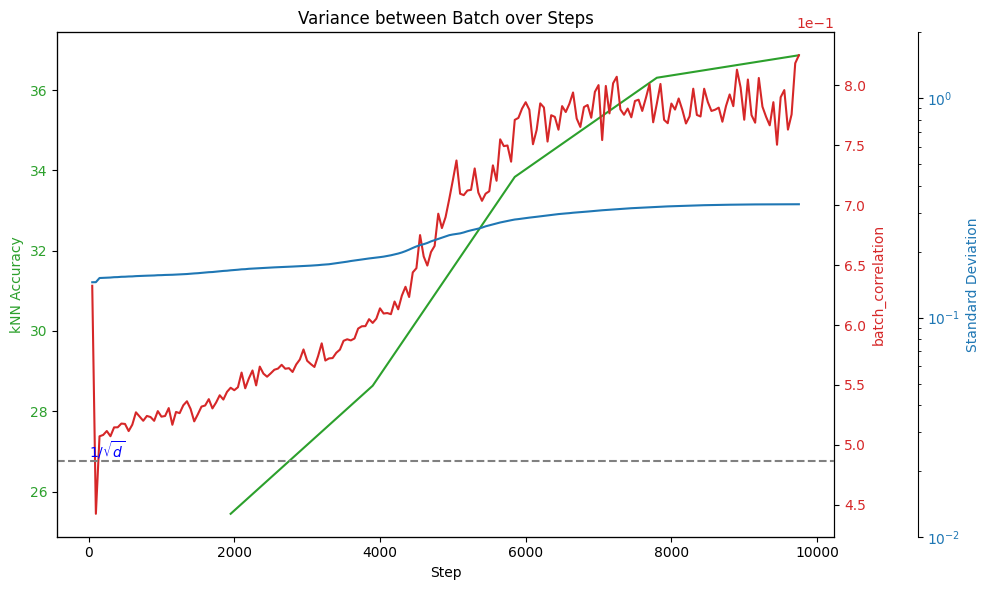

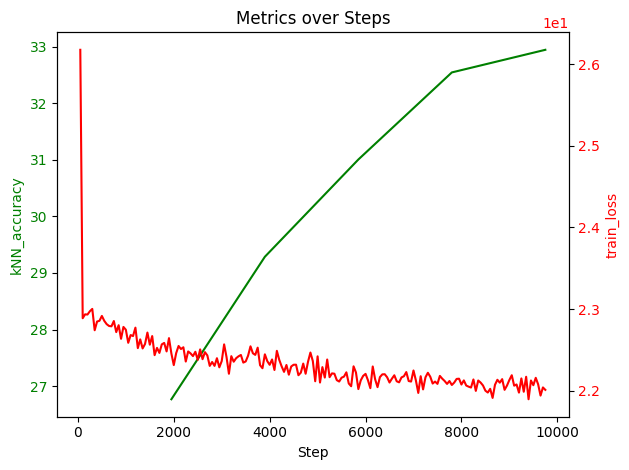

In [7]:
show_batch_variance(root="Model_VICREG_VMmean_n_v4/")
plot_metrics_together(root="Model_VICREG_VMNone_v2//", metrics=['kNN_accuracy','train_loss']) 

# Strategy vs Accuracy

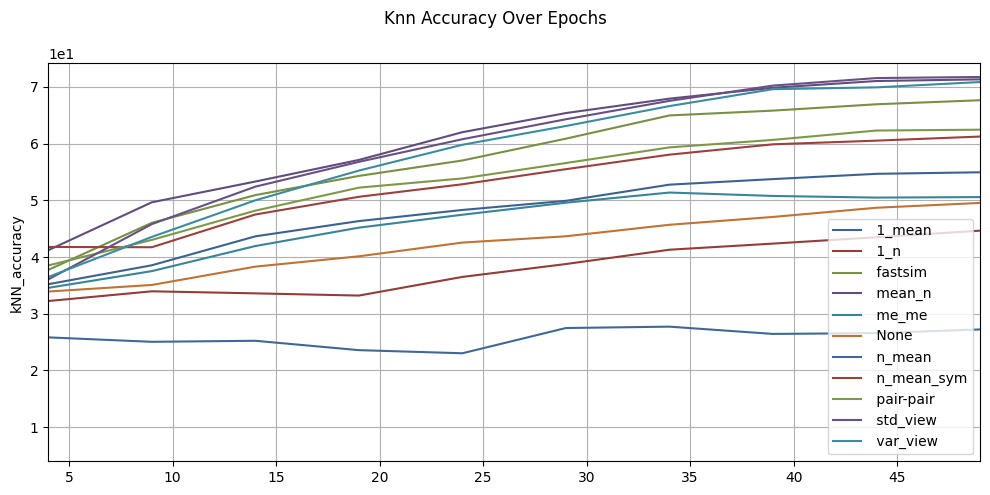

In [8]:
data = compare_curve("LNeg_VM*_PRTruenoBN_stTrue_b128_m50_v4",
                    r"LNeg_VM(.*)_PRTruenoBN_stTrue_b128_m50_v4", 
                    ['kNN_accuracy']
                    )
 

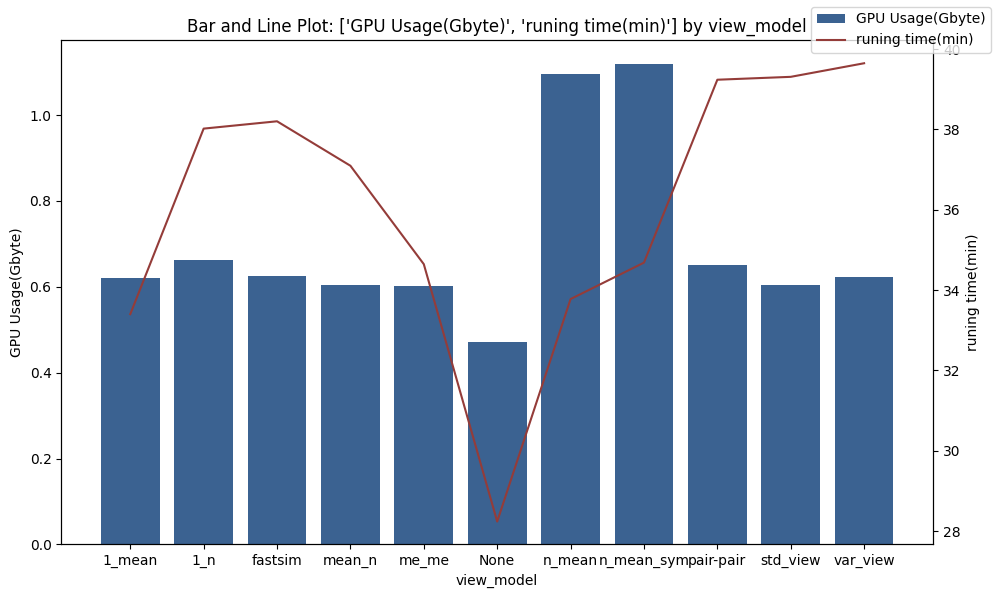

In [9]:
df = check_config("LNeg_VM*_PRTruenoBN_stTrue_b128_m50_v4", ['GPU Usage(Gbyte)', 'runing time(min)',"view_model"])
df
plot_bar(df, X="view_model", Y=["GPU Usage(Gbyte)","runing time(min)"])
 

# Result


 
## Comparison with State-of-the-art： Refresh the Cifar

We compared in CIfar and realized SOTA


In [10]:
import pandas as pd

# Load spreadsheet
xl = pd.ExcelFile('Compare All Model Baseline.xlsx')

# Load a sheet into a DataFrame by its name
df = xl.parse('Sheet1') 

## 3. It can easily improve Most current baselines
We are interested in comparisons between baseline networks and improved networks, not in achieving state-of-the-art performance on MNIST (the described architecture does not). 

C:\Users\isxzl\AppData\Local\Temp\ipykernel_18788\1211131327.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (colname, data) in enumerate(grouped_df.iteritems()):


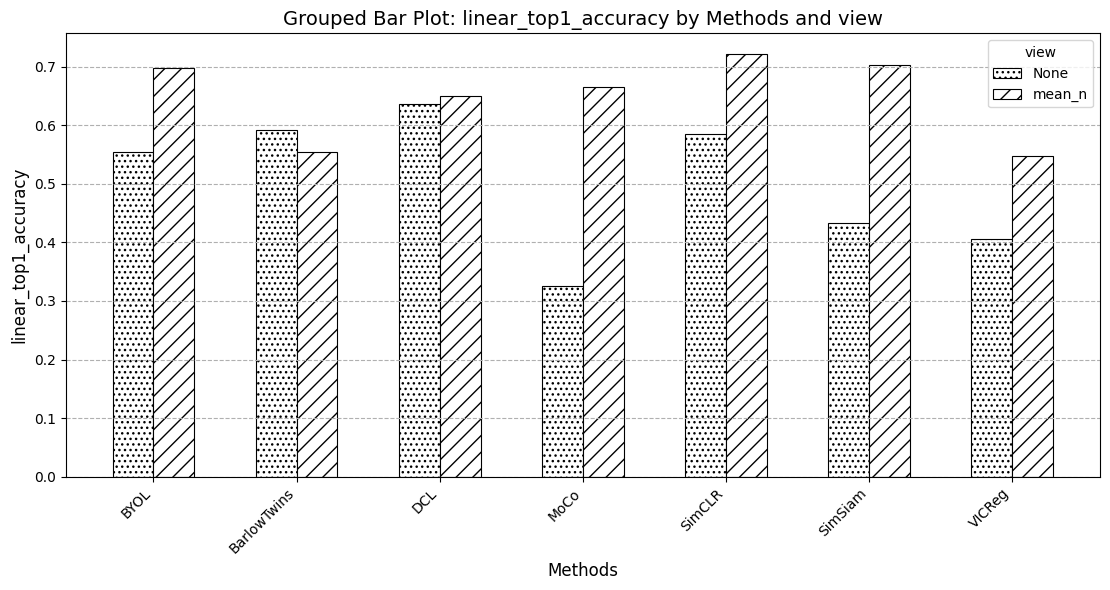

In [7]:
ds=pd.read_csv("../Magic_cube/Base_md.__VM.__ep50_v._.csv")
ds=ds[["dir_name","linear_top1_accuracy"]] #,"linear_top3_accuracy","linear_top1_average_accuracy","linear_knn_top1_accuracy"
df=extract_reg(ds,"VMREG_ep","view")   
df=extract_reg(df,"se_mdREG_VM","Methods")    

# Call the function with the DataFrame and column names
plot_bar(df, X="Methods", Y="linear_top1_accuracy",legend="view")


C:\Users\isxzl\AppData\Local\Temp\ipykernel_18788\2243997742.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["runing time(min)"]=df["backward(min)"]+df["forward(min)"]+df["update(min)"]
C:\Users\isxzl\AppData\Local\Temp\ipykernel_18788\1211131327.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (colname, data) in enumerate(grouped_df.iteritems()):


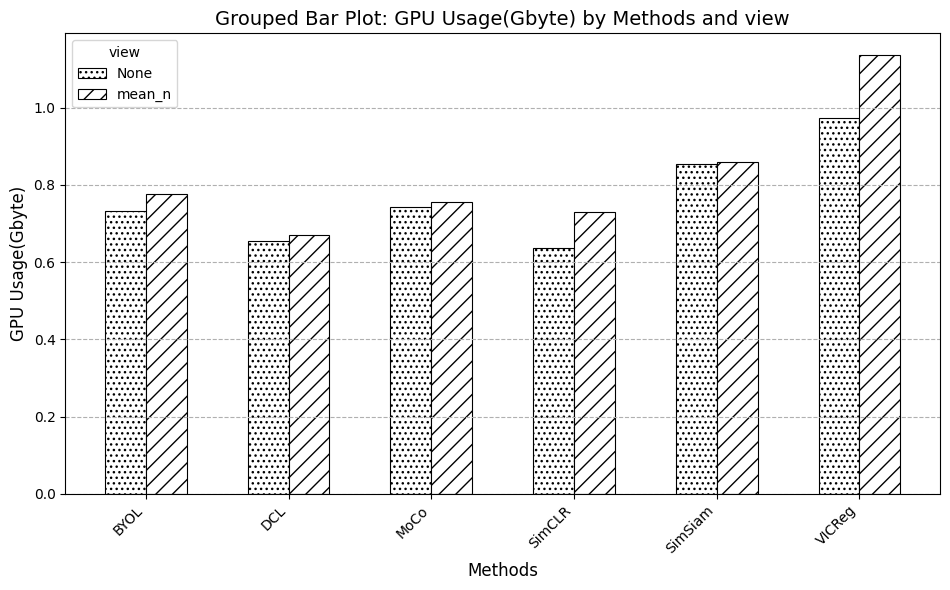

,forward(min),backward(min),update(min),GPU Usage(Gbyte),runing time(min)
Methods,,,,,
BYOL,+1.0%,+97.2%,+13.4%,+6.1%,+13.5%
DCL,+18.9%,+136.5%,+41.6%,+2.4%,+42.0%
MoCo,+2.7%,+103.2%,+15.3%,+1.7%,+15.4%
SimCLR,+8.4%,+117.9%,+28.7%,+14.7%,+29.0%
SimSiam,+28.4%,+84.2%,+39.2%,+0.6%,+39.6%
VICReg,+3.1%,+168.4%,+36.4%,+16.8%,+36.9%
Average,+10.4%,+117.9%,+29.1%,+7.1%,+29.4%


In [12]:
 
ds = check_config("../Magic_cube/Base_md*_VM*_ep50_v*", ['GPU Usage(Gbyte)', 'runing time(min)',"view_model","transform(min)","update(min)","backward(min)","forward(min)"])
 
df=extract_reg(ds,"VMREG_ep","view")   
df=extract_reg(df,"se_mdREG_VM","Methods")
df1=df
df=df[["Methods","forward(min)","backward(min)","update(min)","GPU Usage(Gbyte)","runing time(min)"]]
df["runing time(min)"]=df["backward(min)"]+df["forward(min)"]+df["update(min)"]

base = df[df1["view"] == "None"]
mean_n = df[df1["view"] == "mean_n"]
base.set_index("Methods", inplace=True)
mean_n.set_index("Methods", inplace=True)
# Calculate the percentage difference
df2 = ((mean_n - base) / base) * 100


df2.loc["Average"] = df2.mean()

#df2.round(1)
import pandas as pd

# Assuming you have a dataframe named "df"

# Format all values as percentages with sign and '%'
df_formatted = df2.applymap(lambda x: f'{x:+.1f}%' if isinstance(x, (int, float)) else x)
plot_bar(df1, X="Methods", Y="GPU Usage(Gbyte)",legend="view")
df_formatted

# 4 Ablation Experiment


# Influence of View Number


In [ ]:
 

ds=pd.read_csv("LNeg_VMmean_n_PRTruenoBN_stTrue_b128_m50_v_.csv")
ds=ds[["dir_name","linear_top1_accuracy","linear_top3_accuracy","linear_top1_average_accuracy","linear_knn_top1_accuracy"]]
ds

In [ ]:
df=extract_reg(ds,"_b128_m50_vREG","view")    
plot_lines(df, 'view')


In [ ]:
ds = check_config("LNeg_VMmean_n_PRTruenoBN_stTrue_b128_m50_v*", ['GPU Usage(Gbyte)', 'runing time(min)',"view_model"])

df=extract_reg(ds,"_b128_m50_vREG","view")    

plot_perform(df, 'view')

 
# 3. 
Influence of Batch Normalization


In [ ]:
 

ds=pd.read_csv("LNeg_VMmean_n_PRTruenoBN_stTrue_b.__m50_v4.csv")
ds=ds[["dir_name","linear_top1_accuracy","linear_top3_accuracy","linear_top1_average_accuracy","linear_knn_top1_accuracy"]]
ds

In [ ]:
df=extract_reg(ds,"_stTrue_bREG_m50_v4","batch")    
plot_lines(df, 'batch')


In [ ]:
ds = check_config("LNeg_VMmean_n_PRTruenoBN_stTrue_b*_m50_v4", ['GPU Usage(Gbyte)', 'runing time(min)',"view_model"])

df=extract_reg(ds,"_stTrue_bREG_m50_v4","batch")    

plot_perform(df, 'batch')

In [ ]:
 

ds=pd.read_csv("LNeg_VMNone_PRTruenoBN_stTrue_b.__m50_v4.csv")
ds=ds[["dir_name","linear_top1_accuracy","linear_top3_accuracy","linear_top1_average_accuracy","linear_knn_top1_accuracy"]]
df=extract_reg(ds,"_stTrue_bREG_m50_v4","batch")    
plot_lines(df, 'batch')



# 4.  
Loss function 

# 5.  
 Projection, Stop gradient , batch size etc,.

# Augmentation

In [ ]:
def plot_line(df, X="", Y="", legend="", sort=False):

    # when Y is a list, X is the x-axis, plot the lines with same x axis
    if isinstance(Y, list) and X:
        plt.figure(figsize=(10, 6))
        for y in Y:
            plt.plot(df[X], df[y], label=y)
        plt.xlabel(X, fontsize=12)
        plt.ylabel("Values", fontsize=12)
        plt.title(f"Multiple Line Plot: {Y} by {X}", fontsize=14)
        plt.grid(axis='y', linestyle='--')
        plt.legend(title=legend)
        plt.tight_layout()
        plt.show()

    # when 'X' and 'Y' are specified, but legend is None
    elif X and Y and legend is None:
        plt.figure(figsize=(10, 6))
        plt.plot(df[X], df[Y])
        plt.xlabel(X, fontsize=12)
        plt.ylabel(Y, fontsize=12)
        plt.title(f"Line Plot: {Y} by {X}", fontsize=14)
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

    # when 'X', 'legend', and 'Y' are specified
    elif X and legend and Y:
        grouped_df = df.groupby([X, legend])[Y].sum().unstack()
        if sort:
            
            grouped_df=grouped_df.reset_index(drop=True).reindex([  i-1 for i in [9, 4, 2, 6, 5, 1, 7, 8]  ]).reset_index(drop=True)

        plt.figure(figsize=(10, 6))

        for colname, data in grouped_df.iteritems():
            plt.plot(data.index, data, label=colname)

        plt.xlabel(X, fontsize=12)
        plt.ylabel(Y, fontsize=12)
        plt.title(f"Grouped Line Plot: {Y} by {X} and {legend}", fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(title=legend)

        plt.grid(axis='y', linestyle='--')

        plt.tight_layout()
        plt.show()

    else:
        print("Please specify 'X', 'legend', and 'Y' parameters.")



    
ds=pd.read_csv("../Magic_cube/UA_mdSimSiam_.__ep50_BA128_._.csv")
ds=ds[["dir_name","linear_top1_accuracy"]] #,"linear_top3_accuracy","linear_top1_average_accuracy","linear_knn_top1_accuracy"
df=extract_reg(ds,"BA128_vREG","views")   
df=extract_reg(df,"AREG_VM","The Strength of Augmentation")    

# Call the function with the DataFrame and column names
plot_line(df, X="The Strength of Augmentation", Y="linear_top1_accuracy",legend="views", sort=True)


#顺序是，  9,3，4，2，6，5， 1 ，7， 8

# Conclusion

In [ ]:
X="AUG"
Y="linear_top1_accuracy"
legend="view"   
